<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center> Authors: [Maria Sumarokova](https://www.linkedin.com/in/mariya-sumarokova-230b4054/), senior data scientist/analyst at Veon, and [Yury Kashnitsky](https://www.linkedin.com/in/festline/), data scientist at Mail.Ru Group. <br>Translated and edited by Gleb Filatov, Aleksey Kiselev,<br> [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/) <br>All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center> Assignment #3 (demo)
## <center>  Decision trees with a toy task and the UCI Adult dataset 

Please fill in the answers in the [web-form](https://docs.google.com/forms/d/1wfWYYoqXTkZNOPy1wpewACXaj2MZjBdLOL58htGWYBA/edit).

Let's start by loading all necessary libraries:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### Part 1. Toy dataset "Will They? Won't They?"

Your goal is to figure out how decision trees work by walking through a toy problem. While a single decision tree does not yield outstanding results, other performant algorithms like gradient boosting and random forests are based on the same idea. That is why knowing how decision trees work might be useful.

We'll go through a toy example of binary classification - Person A is deciding whether they will go on a second date with Person B. It will depend on their looks, eloquence, alcohol consumption (only for example), and how much money was spent on the first date.

#### Creating the dataset

In [2]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [3]:
features = ['Looks', 'Alcoholic_beverage','Eloquence','Money_spent']

#### Training data

In [4]:
df_train = {}
df_train['Looks'] = ['handsome', 'handsome', 'handsome', 'repulsive',
                         'repulsive', 'repulsive', 'handsome'] 
df_train['Alcoholic_beverage'] = ['yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes']
df_train['Eloquence'] = ['high', 'low', 'average', 'average', 'low',
                                   'high', 'average']
df_train['Money_spent'] = ['lots', 'little', 'lots', 'little', 'lots',
                                  'lots', 'lots']
df_train['Will_go'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


#### Test data

In [5]:
df_test = {}
df_test['Looks'] = ['handsome', 'handsome', 'repulsive'] 
df_test['Alcoholic_beverage'] = ['no', 'yes', 'yes']
df_test['Eloquence'] = ['average', 'high', 'average']
df_test['Money_spent'] = ['lots', 'little', 'lots']
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [6]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train['Will_go']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Alcoholic_beverage_no,Looks_handsome,Looks_repulsive,Money_spent_little,Money_spent_lots,Eloquence_average,Eloquence_high,Alcoholic_beverage_yes
0,0,1,0,0,1,0,1,1
1,0,1,0,1,0,0,0,1
2,1,1,0,0,1,1,0,0
3,1,0,1,1,0,1,0,0
4,0,0,1,0,1,0,0,1
5,0,0,1,0,1,0,1,1
6,0,1,0,0,1,1,0,1


In [7]:
df_train.columns

Index(['Alcoholic_beverage_no', 'Looks_handsome', 'Looks_repulsive',
       'Money_spent_little', 'Money_spent_lots', 'Eloquence_average',
       'Eloquence_high', 'Alcoholic_beverage_yes'],
      dtype='object')

#### Draw a decision tree (by hand or in any graphics editor) for this dataset. Optionally you can also implement tree construction and draw it here.

In [8]:
y.value_counts(normalize=True)

0    0.571429
1    0.428571
Name: Will_go, dtype: float64

1\. What is the entropy $S_0$ of the initial system? By system states, we mean values of the binary feature "Will_go" - 0 or 1 - two states in total.

In [9]:
def calculate_entropy(sample, print_text, df_name=""):

    probs = []
    probs = pd.Series(sample).value_counts(normalize=True,sort=False).values
    
    s_0 = 0
   
    for i in probs:
        s_0 += (i * np.log2(i))
    s_0 = -s_0
    
    if print_text == True:
        return print("Entropy in the {} sample = {:.3f}".format(df_name, s_0))
        
    else:
        return s_0

In [10]:
prob_0 = y.value_counts(normalize=True)[0]
prob_1 = y.value_counts(normalize=True)[1]

In [11]:
s0 = calculate_entropy(y, print_text=False)

calculate_entropy(y, print_text=True)


Entropy in the  sample = 0.985


2\. Let's split the data by the feature "Looks_handsome". What is the entropy $S_1$ of the left group - the one with "Looks_handsome". What is the entropy $S_2$ in the opposite group? What is the information gain (IG) if we consider such a split?

In [12]:
df_train["Looks_handsome"].value_counts().sum()==len(df_train)

True

In [13]:
df_train.columns

Index(['Alcoholic_beverage_no', 'Looks_handsome', 'Looks_repulsive',
       'Money_spent_little', 'Money_spent_lots', 'Eloquence_average',
       'Eloquence_high', 'Alcoholic_beverage_yes'],
      dtype='object')

In [14]:
df_ugly = df_train[df_train["Looks_handsome"]==0]
df_pretty = df_train[df_train["Looks_handsome"]==1]

In [15]:
df_ugly.index

Int64Index([3, 4, 5], dtype='int64')

In [16]:
df_pretty.index

Int64Index([0, 1, 2, 6], dtype='int64')

In [17]:
y_pretty = y.iloc[df_pretty.index.values]
y_ugly = y.iloc[df_ugly.index.values]

In [18]:
s_p = calculate_entropy(y_pretty, print_text=False, df_name="pretty ")
calculate_entropy(y_pretty, print_text=True, df_name="pretty ")

Entropy in the pretty  sample = 0.811


In [19]:
s_u = calculate_entropy(y_ugly, print_text=False, df_name="ugly ")
calculate_entropy(y_ugly, print_text=True, df_name="ugly ")

Entropy in the ugly  sample = 0.918


Information gain:
$$\Large IG(Q) = S_O - \sum_{i=1}^{q}\frac{N_i}{N}S_i,$$

Where:
    - Ni is the number of samples in the subsample created by the split
    - N is the total number of samples
    - s0 is the entropy in the initial sample
    - si is the entropy in each subsample created by the split

In [20]:
ig_q = s0 - (len(df_ugly)/len(df_train) * s_u + len(df_pretty)/len(df_train) * s_p)

In [21]:
print("The information gain in the sample after the split is {:.3f}".format(ig_q))

The information gain in the sample after the split is 0.128


#### Train a decision tree using sklearn on the training data. You may choose any depth for the tree.

In [22]:
clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(df_train, y)

#### Additional: display the resulting tree using graphviz. You can use pydot or [web-service](https://www.coolutils.com/ru/online/DOT-to-PNG) dot2png.

In [23]:
import pydotplus
from io import StringIO
from ipywidgets import Image



In [24]:
col_list = [col for col in df_train.columns]

In [25]:
col_list

['Alcoholic_beverage_no',
 'Looks_handsome',
 'Looks_repulsive',
 'Money_spent_little',
 'Money_spent_lots',
 'Eloquence_average',
 'Eloquence_high',
 'Alcoholic_beverage_yes']

In [26]:
dot_data = StringIO()

export_graphviz(clf,
                out_file=dot_data, feature_names=col_list, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(value=graph.create_png())

### Part 2. Functions for calculating entropy and information gain.

Consider the following warm-up example: we have 9 blue balls and 11 yellow balls. Let ball have label **1** if it is blue, **0** otherwise.

In [27]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

<img src = '../../img/decision_tree3.png'>

Next split the balls into two groups:

<img src = '../../img/decision_tree4.png'>

In [28]:
# two groups
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 blue and 6 yellow

#### Implement a function to calculate the Shannon Entropy

#### Entropy
Shannon's entropy is defined for a system with N possible states as follows:

$$\Large S = -\sum_{i=1}^{N}p_i \log_2{p_i},$$

In [29]:
def entropy(sample):

    probs = []
    probs = pd.Series(sample).value_counts(normalize=True,sort=False).values
    
    s_0 = 0
   
    for i in probs:
        s_0 += (i * np.log2(i))
        
    return -s_0

In [30]:
print(entropy(balls)) # 9 blue and 11 yellow
print(entropy(balls_left)) # 8 blue and 5 yellow
print(entropy(balls_right)) # 1 blue and 6 yellow
print(entropy([1,2,3,4,5,6])) # entropy of a fair 6-sided dice

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


3\. What is the entropy of the state given by the list **balls_left**?

In [31]:
print(entropy(balls_left)) # 8 blue and 5 yellow


0.9612366047228759


4\. What is the entropy of a fair dice? (where we look at a dice as a system with 6 equally probable states)?

In [32]:
print(entropy([1,2,3,4,5,6])) # entropy of a fair 6-sided dice

2.584962500721156


In [33]:
# information gain calculation
def information_gain(root, left, right):
    ''' root - initial data, left and right - two partitions of initial data'''

    s0 = entropy(root)
    s1 = entropy(left)
    s2 = entropy(right)
    
    n1_div_n = len(left) / len(root)
    n2_div_n = len(right) / len(root)
    
    ig = s0 - (n1_div_n * s1 + n2_div_n * s2)
    return ig

5\. What is the information gain from splitting the initial dataset into **balls_left** and **balls_right** ?

In [34]:
information_gain(balls,balls_left,balls_right)

0.16088518841412436

In [35]:
# you code here

In [36]:
df_train

,Alcoholic_beverage_no,Looks_handsome,Looks_repulsive,Money_spent_little,Money_spent_lots,Eloquence_average,Eloquence_high,Alcoholic_beverage_yes
0,0,1,0,0,1,0,1,1
1,0,1,0,1,0,0,0,1
2,1,1,0,0,1,1,0,0
3,1,0,1,1,0,1,0,0
4,0,0,1,0,1,0,0,1
5,0,0,1,0,1,0,1,1
6,0,1,0,0,1,1,0,1


In [37]:
col_list[clf.feature_importances_.argmax()]

'Money_spent_lots'

In [38]:
def best_feature_to_split(X, y):
    '''Outputs information gain when splitting on best feature'''
    clf = DecisionTreeClassifier(criterion='entropy')
    clf.fit(X,y)
    # you code here
    pass

#### Optional:
- Implement a decision tree building algorithm by calling **best_feature_to_split** recursively
- Plot the resulting tree

### Part 3. The "Adult" dataset

#### Dataset description:

[Dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/adult) UCI Adult (no need to download it, we have a copy in the course repository): classify people using demographical data - whether they earn more than \$50,000 per year or not.

Feature descriptions:

- **Age** – continuous feature
- **Workclass** –  continuous feature
- **fnlwgt** – final weight of object, continuous feature
- **Education** –  categorical feature
- **Education_Num** – number of years of education, continuous feature
- **Martial_Status** –  categorical feature
- **Occupation** –  categorical feature
- **Relationship** – categorical feature
- **Race** – categorical feature
- **Sex** – categorical feature
- **Capital_Gain** – continuous feature
- **Capital_Loss** – continuous feature
- **Hours_per_week** – continuous feature
- **Country** – categorical feature

**Target** – earnings level, categorical (binary) feature.

#### Reading train and test data

In [39]:
data_train = pd.read_csv('../../data/adult_train.csv', sep=';')

In [40]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [41]:
data_test = pd.read_csv('../../data/adult_test.csv', sep=';')

In [42]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [43]:
# necessary to remove rows with incorrect labels in test dataset
data_test = data_test[(data_test['Target'] == ' >50K.') | (data_test['Target']==' <=50K.')]

# encode target variable as integer
data_train.loc[data_train['Target']==' <=50K', 'Target'] = 0
data_train.loc[data_train['Target']==' >50K', 'Target'] = 1

data_test.loc[data_test['Target']==' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target']==' >50K.', 'Target'] = 1

#### Primary data analysis

In [44]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281,NaN,NaN,NaN,189436,105715,13492,116736,177831,238384,1.4904e+06
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281,NaN,NaN,NaN,10.0729,2.56755,1,9,10,12,16
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

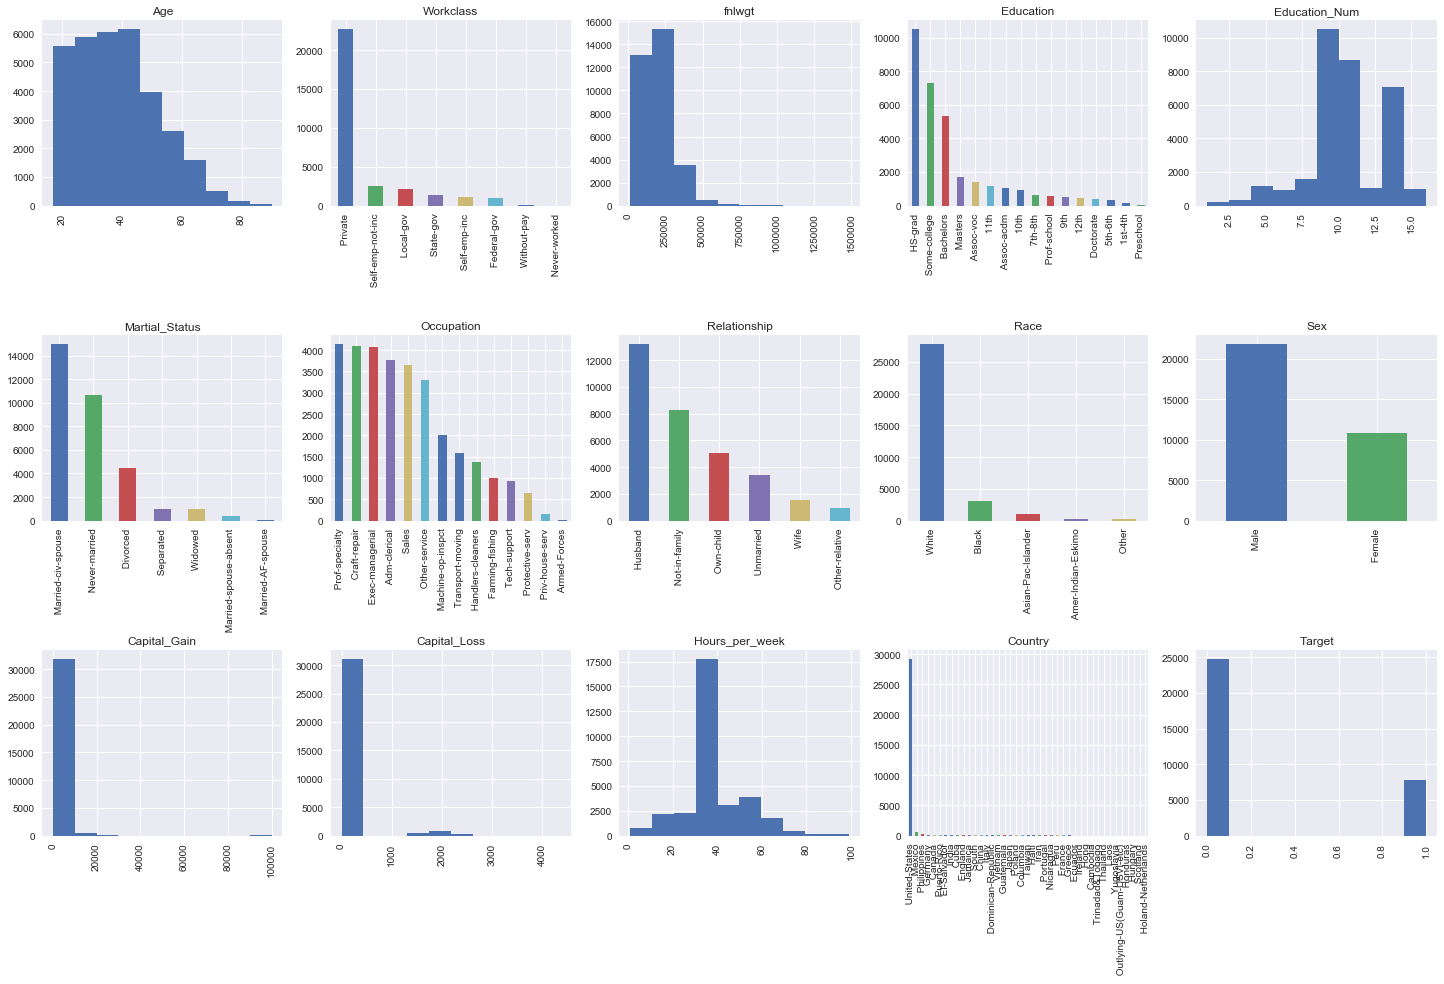

In [46]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

#### Checking data types

In [47]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target             int64
dtype: object

In [48]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target              int64
dtype: object

As we see, in the test data, age is treated as type **object**. We need to fix this.

In [49]:
data_test['Age'] = data_test['Age'].astype(int)

Also we'll cast all **float** features to **int** type to keep types consistent between our train and test data.

In [50]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

#### Fill in missing data for continuous features with their median values, for categorical features with their mode.

In [51]:
# choose categorical and continuous features from data

categorical_columns = [c for c in data_train.columns 
                       if data_train[c].dtype.name == 'object']
numerical_columns = [c for c in data_train.columns 
                     if data_train[c].dtype.name != 'object']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target']


In [52]:
# fill missing data

for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode(), inplace=True)
    data_test[c].fillna(data_train[c].mode(), inplace=True)
    
for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

We'll dummy code some categorical features: **Workclass**, **Education**, **Martial_Status**, **Occupation**, **Relationship**, **Race**, **Sex**, **Country**. It can be done via pandas method **get_dummies**

In [53]:
data_train = pd.concat([
    pd.get_dummies(data_train[categorical_columns]),
    data_train[numerical_columns]], axis=1)

data_test = pd.concat([
    pd.get_dummies(data_test[categorical_columns]),
    data_test[numerical_columns]], axis=1)

In [54]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [55]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

#### There is no Holland in the test data. Create new zero-valued feature.

In [56]:
data_test['Country_ Holand-Netherlands'] = 0

In [57]:
set(data_train.columns) - set(data_test.columns)

set()

In [58]:
data_train.head(2)

,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,Education_ 10th,Education_ 11th,...,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target
0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,39,77516,13,2174,0,40,0
1,0,0,0,0,0,1,0,0,0,0,...,1,0,0,50,83311,13,0,0,13,0


In [59]:
data_test.head(2)

,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,Education_ 10th,Education_ 11th,...,Country_ Vietnam,Country_ Yugoslavia,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Country_ Holand-Netherlands
1,0,0,0,1,0,0,0,0,0,1,...,0,0,25,226802,7,0,0,40,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,38,89814,9,0,0,50,0,0


In [60]:
X_train = data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

### 3.1 Decision tree without parameter tuning

Train a decision tree **(DecisionTreeClassifier)** with a maximum depth of 3, and evaluate the accuracy metric on the test data. Use parameter **random_state = 17** for results reproducibility.

In [99]:
tree = RandomForestClassifier(random_state=17, max_depth=9)
tree.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

Make a prediction with the trained model on the test data.

In [100]:
tree_predictions = tree.predict(X_test)

In [101]:
tree_predictions

array([0, 0, 0, ..., 0, 0, 0])

In [104]:
# you code here
# accuracy_score 
tree.score(X_train,y_train)

0.8576517920211296

6\. What is the test set accuracy of a decision tree with maximum tree depth of 3 and **random_state = 17**?

### 3.2 Decision tree with parameter tuning

Train a decision tree **(DecisionTreeClassifier, random_state = 17).** Find the optimal maximum depth using 5-fold cross-validation **(GridSearchCV)**.

In [106]:
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV(clf,tree_params) # you code here                     

locally_best_tree.fit(X_train,y_train) # you code here 

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(2, 11)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [107]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.853751420410921


Train a decision tree with maximum depth of 9 (it is the best **max_depth** in my case), and compute the test set accuracy. Use parameter **random_state = 17** for reproducibility.

In [66]:
tuned_tree = # you code here 
tuned_tree.fit # you code here 
tuned_tree_predictions = tuned_tree.predict # you code here 
accuracy_score # you code here 

7\. What is the test set accuracy of a decision tree with maximum depth of 9 and **random_state = 17**?

### 3.3 (Optional) Random forest without parameter tuning

Let's take a sneak peek of upcoming lectures and try to use a random forest for our task. For now, you can imagine a random forest as a bunch of decision trees, trained on slightly different subsets of the training data.

Train a random forest **(RandomForestClassifier)**. Set the number of trees to 100 and use **random_state = 17**.

In [67]:
# rf = # you code here 
# rf.fit # you code here 

Make predictions for the test data.

In [68]:
# forest_predictions = rf.predict # you code here 

In [69]:
# accuracy_score # you code here 

### 3.4 (Optional) Random forest with parameter tuning

Train a random forest **(RandomForestClassifier)**. Tune the maximum depth and maximum number of features for each tree using **GridSearchCV**. 

In [70]:
# forest_params = {'max_depth': range(10, 21),
#                 'max_features': range(5, 105, 20)}

# locally_best_forest = GridSearchCV # you code here 

# locally_best_forest.fit # you code here 

In [71]:
# print("Best params:", locally_best_forest.best_params_)
# print("Best cross validaton score", locally_best_forest.best_score_)

Make predictions for the test data.

In [72]:
# tuned_forest_predictions = locally_best_forest.predict # you code here 
# accuracy_score # you code here 